In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [11]:
reviews = pd.read_csv('data/reviews.csv.gz')
listings = pd.read_csv('data/listings.csv.gz')

In [37]:
listings.amenities = listings.amenities.map(lambda x: ast.literal_eval(x))
listings['amenities_count'] = listings.amenities.apply(len)

In [38]:
listings = listings.join(listings.amenities.str.join('|').str.get_dummies().add_prefix('amenity_'))

In [39]:
def find_baths(bathrooms_text):
    if not isinstance(bathrooms_text, str):
        return 0
    elif re.search(r'half', bathrooms_text, flags=re.IGNORECASE):
        return 0.5
    else:
        return float(re.findall("(\d+(?:\.\d+)?)", bathrooms_text)[0])

In [40]:
listings.bathrooms = listings.bathrooms_text.map(find_baths)

In [41]:
listings.price = listings.price.str.replace(r'[,|$]', '').astype('float')

AttributeError: Can only use .str accessor with string values!

In [63]:
listings.host_is_superhost = LabelEncoder().fit_transform(listings.host_is_superhost)

In [68]:
columns = [
    'host_is_superhost', 'host_listings_count', 'neighbourhood_cleansed',
    'room_type', 'bathrooms', 'beds', 'price', 'availability_365', 
    'number_of_reviews', 'amenity_TV', 'amenity_Lock on bedroom door', 
    'amenity_Dishwasher', 'amenity_Dryer', 'amenity_Private entrance', 
    'amenity_Shampoo', 'amenity_Hair dryer', 'amenity_Oven', 
    'amenity_Iron', 'amenity_Stove'
]

In [69]:
listings_mini = listings[columns]

In [70]:
listings_mini = listings_mini\
            .join(pd.get_dummies(listings_mini.neighbourhood_cleansed))\
            .join(pd.get_dummies(listings_mini.room_type))
listings_mini = listings_mini.drop(['neighbourhood_cleansed', 'room_type',], axis=1)

In [72]:
listings_mini.isnull().sum().nlargest(5)

beds                   1219
host_listings_count      46
host_is_superhost         0
bathrooms                 0
price                     0
dtype: int64

In [73]:
listings_mini.fillna(1, inplace=True)

In [74]:
listings_mini.isnull().sum().nlargest(5)

host_is_superhost      0
host_listings_count    0
bathrooms              0
beds                   0
price                  0
dtype: int64

In [82]:
len(listings_mini[listings_mini.price < 500]) / len(listings_mini)

0.9827004991245721

In [80]:
listings_mini = listings_mini[listings_mini.price < 500]

In [85]:
y = listings_mini.price
x = listings_mini.drop('price', axis=1)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2)

In [90]:
baseline = train_y.mean()
baseline_error = np.sqrt(mean_squared_error(test_y, [baseline] * len(test_y)))
baseline_error

75.0674959318847

In [92]:
for model in [LinearRegression, RandomForestRegressor, xgb.XGBRegressor]:
    predictions = model().fit(train_x, train_y).predict(test_x)
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    print(rmse)

52.83847564890748
48.72526638120101
46.97663160786178


In [78]:
listings_mini[listings_mini.price < 500].shape

(75210, 54)

In [102]:
random_grid = { 
    'n_estimators': np.arange(10, 400, 10),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': np.arange(1, 5),
    'max_depth': np.arange(2, 7),
    'gamma' : [0.1, 0.2, 0.3, 0.4],
    'subsample': np.linspace(0.2, 1, 5),
    'colsample_bytree': np.linspace(0.2, 0.8, 5)
}

In [109]:
xgb_regressor = xgb.XGBRegressor(booster='gbtree', eval_metric='rmse')
xgb_random = RandomizedSearchCV(xgb_regressor, random_grid, n_iter=20, verbose=2, cv=5, n_jobs=-1)
xgb_random.fit(train_x, train_y)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='rmse', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                   param_distributions={'colsample_bytree': array([0.2 , 0.35, 0.5 , 0.65, 0.8 ]),
                                        'gamma': [0.1, 0.2, 0.3, 0.4],
                     

In [131]:
xgb_model = xgb_random.best_estimator_.fit(train_x, train_y)
predictions = xgb_model.predict(test_x)
np.sqrt(mean_squared_error(test_y, predictions))

46.70821718921492

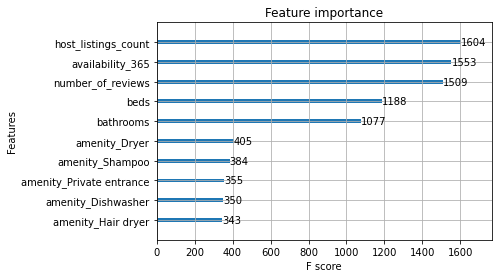

In [116]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

<AxesSubplot:xlabel='price'>

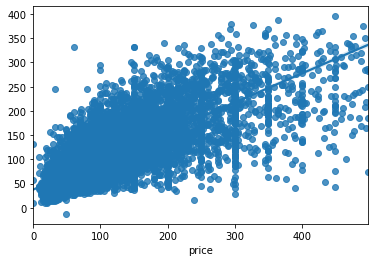

In [126]:
sns.regplot(test_y, predictions)

In [129]:
f'{r2_score(test_y, predictions):.3}'

'0.613'